# GPyTorch Regression Tutorial

Adjust the example from [the online doc](https://docs.gpytorch.ai/en/v1.12/examples/01_Exact_GPs/Simple_GP_Regression.html) using different training data.

## Imports

In [23]:
import logging
import math

from dotenv import load_dotenv

import gpytorch

from matplotlib import pyplot as plt

import seaborn as sns

import torch


%load_ext autoreload
%autoreload 2

# Logger
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%I:%M:%S'
)

# Load dotenv
_ = load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define training data

In [24]:
from sklearn.model_selection import train_test_split

from gp_sand.generate import homoscedastic_data

x, y, y_true = homoscedastic_data(5000)


splits= train_test_split(x, y, y_true)
x_train, x_test = splits[:2]
y_train, y_test = splits[2:4]
y_true_train, y_true_test = splits[4:]



## Visualize training data

[(-15.0, 15.0)]

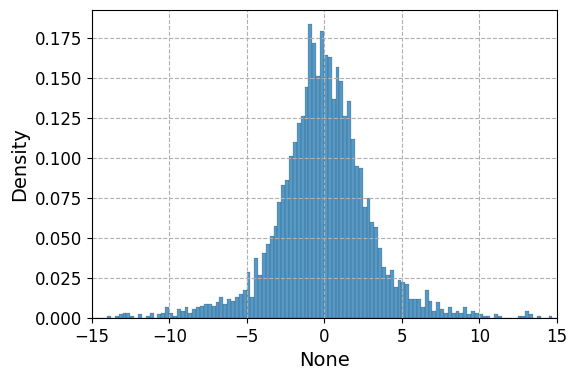

In [36]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.histplot(
    x=x_train,
    binwidth=0.25,
    pthresh=0.01,
    stat='density',
)

ax.set(xlim=(-15, 15))

<Axes: >

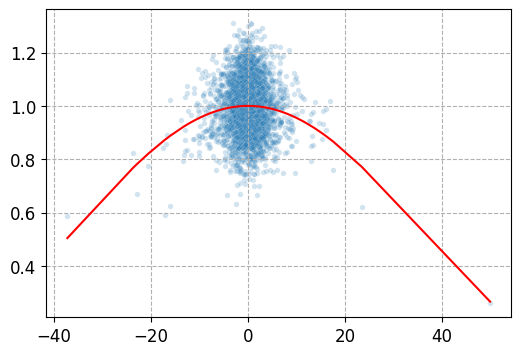

In [25]:
_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

sns.lineplot(
    x=x_train,
    y=y_true_train,
    zorder=10,
    color='r'
)

sns.scatterplot(
    x=x_train,
    y=y_train,
    s=15,
    alpha=.2,
)

## Set up the Model

In [26]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(
        self,
        x_train,
        y_train,
        likelihood
    ):

        # x_train = torch.tensor(x_train).to(torch.float32)
        # y_train = torch.tensor(y_train).to(torch.float32)
        super(ExactGPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
x_train = torch.tensor(x_train).to(torch.float32)
y_train = torch.tensor(y_train).to(torch.float32)
model = ExactGPModel(
    x_train,
    y_train,
    likelihood
)



## Train the model

In [27]:
n_epochs = 50

# Find optimal hyperparameters
model.train()
likelihood.train()

# Use Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Marginal likelihood to serve as loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


# _x, _y = [torch.tensor(el) for el in [x_train, y_train]]
for n in range(n_epochs):
    # Set gradients to zero
    model.zero_grad()

    # Get ouput
    pred = model(x_train)

    # Loss and update params
    # loss = -mll(pred, model._train_targets)
    loss = -mll(pred, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        n + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.764   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.726   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.687   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 0.648   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 0.609   lengthscale: 0.910   noise: 0.513
Iter 6/50 - Loss: 0.571   lengthscale: 0.968   noise: 0.474
Iter 7/50 - Loss: 0.531   lengthscale: 1.029   noise: 0.437
Iter 8/50 - Loss: 0.488   lengthscale: 1.092   noise: 0.403
Iter 9/50 - Loss: 0.447   lengthscale: 1.155   noise: 0.370
Iter 10/50 - Loss: 0.405   lengthscale: 1.219   noise: 0.340
Iter 11/50 - Loss: 0.364   lengthscale: 1.284   noise: 0.312
Iter 12/50 - Loss: 0.322   lengthscale: 1.347   noise: 0.286
Iter 13/50 - Loss: 0.278   lengthscale: 1.411   noise: 0.261
Iter 14/50 - Loss: 0.235   lengthscale: 1.476   noise: 0.239
Iter 15/50 - Loss: 0.190   lengthscale: 1.541   noise: 0.218
Iter 16/50 - Loss: 0.147   lengthscale: 1.606   noise: 0.199
Iter 17/50 - Loss: 0.102   length

## Make predictions

In [28]:
# likelihood(model(torch.tensor(x_test).to(torch.float32)))

In [29]:
# likelihood(model(torch.tensor(x_test).to(torch.float32)))

In [30]:
# observed_pred

In [31]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
x_test.sort()
x_test = torch.tensor(x_test).to(torch.float32)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(x_test))

## Plot model fit

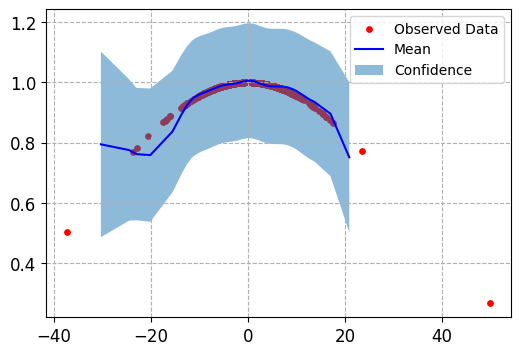

In [32]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.grid(ls='--')

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(x_train, y_true_train, s=15, c='r',)
    # Plot predictive means as blue line
    ax.plot(x_test, observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test, lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


In [33]:
observed_pred.mean

tensor([0.7942, 0.7756, 0.7751,  ..., 0.9352, 0.8959, 0.7512])